# Basic examples

In this notebook we will show how to compute power spectra with local or global line-of-sight, how to dump them to disk, etc.
You need to have installed **pypower** with:
```
python -m pip install git+https://github.com/adematti/pypower#egg=pypower[extras]
```
(extras include sympy and numexpr for faster spherical harmonics)

In [1]:
import os
import tempfile

import numpy as np
from matplotlib import pyplot as plt

from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerSpectrumStatistic, setup_logging

# To activate logging
setup_logging()

In [2]:
def generate_catalogs(size=10000, boxsize=(1000,)*3, offset=(1000.,0,0), seed=42):
    rng = np.random.RandomState(seed=seed)
    toret = []
    for i in range(2):
        positions = [o + rng.uniform(0., 1., size)*b for o,b in zip(offset,boxsize)]
        weights = rng.uniform(0.5, 1., size)
        toret.append((positions, weights))
    return toret

In [3]:
# First, generate fake data with cartesian positions and weights
(data_positions1, data_weights1), (data_positions2, data_weights2) = generate_catalogs(size=10000, seed=42)
(randoms_positions1, randoms_weights1), (randoms_positions2, randoms_weights2) = generate_catalogs(size=50000, seed=84)

## High-level interface
Here we use the high-level interface, starting from the catalogs directly.

In [4]:
# Compute the cross-power spectrum multipoles of order (0, 2, 4), with 10 bins between 0 and 0.2
# using local line-of-sight, box physical size of 2000, mesh size of 256^3, TSC assignment scheme,
# interlacing correction (2nd order)
# los can be None (local) or any box axis ('x', 'y', 'z') or 3-vecto
# Input positions, weights are gathered (not MPI-scattered), so we tell CatalogFFTPower
# to take positions and weights from rank 0 (mpiroot = 0)
kedges = np.linspace(0, 0.2, 11)
ells = (0, 2, 4)
result = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                         data_positions2=data_positions2, data_weights2=data_weights2,
                         randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                         randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                         edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                         los=None, position_type='xyz', mpiroot=0)
# Note that you can also provide single data/randoms catalogs (auto-correlation),
# no randoms (uniform selection function), no weights (assumed unity)
# Or provide "shifted" randoms ("shifted_positions", "shifted_weights") for reconstruction;
# See https://github.com/cosmodesi/pyrecon/blob/main/nb/e2e_examples.ipynb

[000000.06]  01-18 11:55  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   499.99200437  499.99818966], dtype=float64).
[000000.12]  01-18 11:55  CatalogMesh                  INFO     Running interlacing at order 2.
[000000.34]  01-18 11:55  CatalogFFTPower              INFO     Done painting catalog 1 to mesh.
[000000.34]  01-18 11:55  CatalogFFTPower              INFO     Painting catalog 2 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   499.99200437  499.99818966], dtype=float64).
[000000.40]  01-18 11:55  CatalogMesh                  INFO     Running interlacing at order 2.
[000000.62]  01-18 11:55  CatalogFFTPower              INFO     Done painting catalog 2 to mesh.
[000000.62]  01-18 11:55  CatalogFFTPower              INFO     Using 10 k-bins between 0.000 and 0.200.
[000000.78]  01-18 11:55  CatalogFFTPower              INFO  

Shot noise is 0.0000.
Normalization is 0.0548.


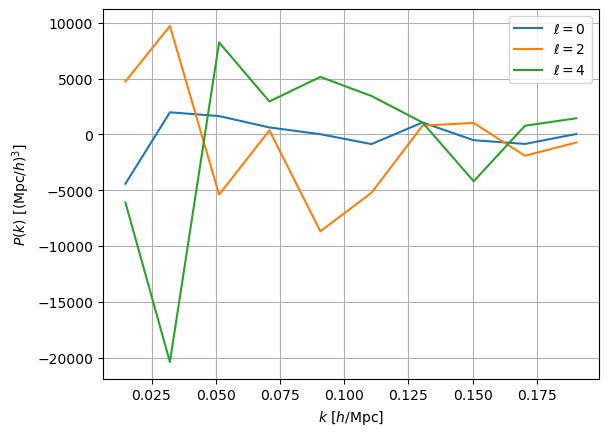

In [5]:
poles = result.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles.wnorm))
ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    ax.plot(poles.k, poles(ell=ell, complex=False), label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel('$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()
# Zero power, as expected

In [6]:
# You can save the result
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    result.save(fn)
    # And reload the result
    result = CatalogFFTPower.load(fn)
    print(result.poles.ells)
# You can also only save multipoles
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    result.poles.save(fn)
    # And reload the result
    poles = PowerSpectrumStatistic.load(fn)
    print(poles.ells, type(poles))

[000004.33]  01-18 11:55  CatalogFFTPower              INFO     Saving /tmp/tmpk51rms2u/tmp.npy.
[000004.33]  01-18 11:55  CatalogFFTPower              INFO     Loading /tmp/tmpk51rms2u/tmp.npy.
(0, 2, 4)
[000004.33]  01-18 11:55  PowerSpectrumMultipole       INFO     Saving /tmp/tmp8uurna_g/tmp.npy.
[000004.34]  01-18 11:55  PowerSpectrumStatistic       INFO     Loading /tmp/tmp8uurna_g/tmp.npy.
(0, 2, 4) <class 'pypower.fft_power.PowerSpectrumMultipole'>


## Catalog mesh
Internally, CatalogFFTPower build one (two if cross-power) CatalogMesh instances (with same mesh) and pass them to MeshFFTPower.

In [7]:
# Here we let it choose the box size
mesh1 = CatalogMesh(data_positions=data_positions1, data_weights=data_weights1,
                    randoms_positions=randoms_positions1, randoms_weights=randoms_weights1,
                    interlacing=2, boxsize=None, nmesh=128, resampler='tsc', position_type='xyz', mpiroot=0)
# Here again, for uniform selection function, just do not provide randoms
# Here we provide global line-of-sight and mu-edges
muedges = np.linspace(-1., 1., 4)
result = MeshFFTPower(mesh1, edges=(kedges, muedges), los='x')

[000004.37]  01-18 11:55  MeshFFTPower                 INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[1999.94622506 1999.94622506 1999.94622506], boxcenter=[1499.9920812   500.00036096  500.02196033], dtype=float64).
[000004.45]  01-18 11:55  CatalogMesh                  INFO     Running interlacing at order 2.
[000004.70]  01-18 11:55  MeshFFTPower                 INFO     Done painting catalog 1 to mesh.
[000004.70]  01-18 11:55  MeshFFTPower                 INFO     Using 10 k-bins between 0.000 and 0.200.
[000004.78]  01-18 11:55  MeshFFTPower                 INFO     Running power spectrum estimation.
[000005.25]  01-18 11:55  MeshFFTPower                 INFO     Power spectrum computed in elapsed time 0.46 s.


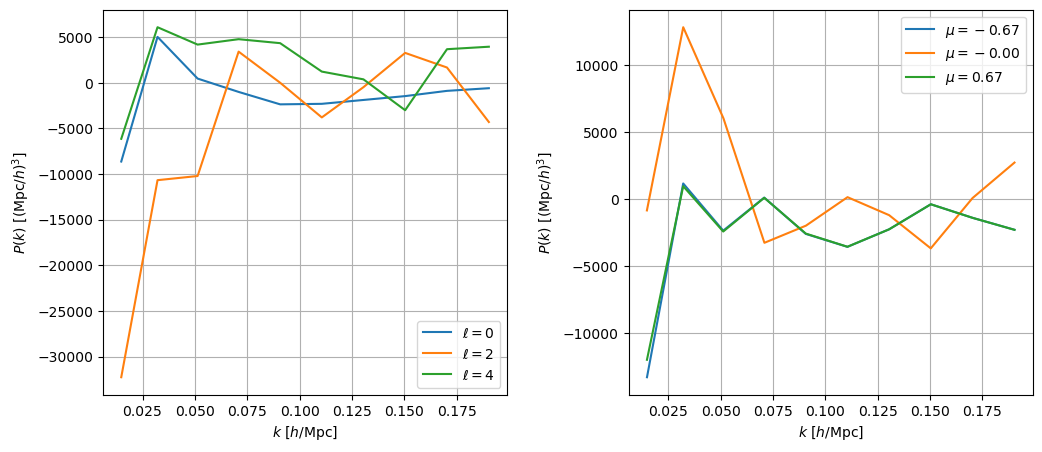

In [8]:
poles = result.poles
wedges = result.wedges
fig, lax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.subplots_adjust(wspace=0.3)
lax = lax.flatten()
for ill, ell in enumerate(poles.ells):
    lax[0].plot(poles.k, poles(ell=ell, complex=False), label='$\ell = {:d}$'.format(ell))
# With global line-of-sight, we also have wedges
for imu, mu in enumerate(wedges.muavg):
    lax[1].plot(wedges.k[:,imu], wedges(mu=mu, complex=False), label='$\mu = {:.2f}$'.format(mu))
for ax in lax:
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('$k$ [$h/\mathrm{Mpc}$]')
    ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()
# Zero power, as expected

## Rebinning
We provide methods to rebin power spectrum estimation accurately, i.e. taking the number of $k$-modes into account.

In [9]:
print('Initial k-modes {}.'.format(poles.kavg))
poles.rebin(2)
print('After rebinning {}.'.format(poles.kavg))

Initial k-modes [0.01483472 0.03215042 0.05129251 0.07087069 0.09070497 0.11058973
 0.13047672 0.15038655 0.1703575  0.19034838].
After rebinning [0.0300727  0.06426886 0.10259729 0.14184564 0.18145079].


In [10]:
print('Initial k-modes {}, mu-modes {}.'.format(wedges.kavg, wedges.muavg))
wedges.rebin((2,3))
print('After rebinning {}, {}.'.format(poles.kavg, wedges.muavg))

Initial k-modes [0.01483472 0.03215042 0.05129251 0.07087069 0.09070497 0.11058973
 0.13047672 0.15038655 0.1703575  0.19034838], mu-modes [-6.66912929e-01 -1.21998220e-04  6.66790655e-01].
After rebinning [0.0300727  0.06426886 0.10259729 0.14184564 0.18145079], [-4.35496713e-17].
